### Machine learning in geoscience with scikit-learn - notebook 2

Matteo Niccoli, MyCarta - Calgary, Alberta, Canada

mycarta.wordpress.com

matteo@mycarta.ca

This is the second notebook in a series about Machine Learning in geoscience. The overall **goal** of this series of notebooks is to **predict P-wave velocity from other geophysical logs** using Machine Learning. The aspiration is to show that some of these models perform better than multivariate linear regression.

The notebooks accompany a <a href="https://mycarta.wordpress.com/2016/10/01/machine-learning-in-geoscience-with-scikit-learn-series-outline/"> series of blog post on MyCarta</a>:

1) Machine learning in geoscience with scikit-learn. Part 1: checking, tidying, and analyzing the dataset

2) Machine learning in geoscience with scikit-learn. Part 2: using inferential statistics to select features

3) Machine learning in geoscience with scikit-learn. Part 3: evaluating and comparing algorithms

4) Machine learning in geoscience with scikit-learn. Part 4: improving results with algorithm tuning

In the  <a href="https://github.com/mycarta/predict/blob/master/Geoscience_Machine_Learning_notebook_1.ipynb"> first notebook</a> I showed how to use Pandas, Seaborn, and Matplotlib to:
- load the <a href="https://github.com/mycarta/predict/blob/master/qsiwell2_predict.cs"> dataset</a> 
- test, clean up, and summarize the data
- start looking for relationships between variables using scatterplots and correlation coefficients

In this second notebook I will expand on the latter point by introducing some tests and visualizations that will help  highlight the possible criteria for choosing some variables, and dropping others. 

I will not recommend, as you will see, to run the tests and apply the criteria blindly, but more to use them as a way to learn more about the data, and in conjunction with domain knowledge about the data, make more informed choices.

I will use a different dataset from notebook 1. This one is from the paper **Many correlation coefficients, null hypoteses, and high value (Hunt, 2013, Reference 1)**

The target variable to be predicted, Y, is oil production (measured in tens of barrels of oil per day) from a marine barrier sand. As Hunt does in the paper, I will not use the variable names initially, so if you want to follow along without spoiling some surprises, just read on, and go back to the paper later.

#### A NOTE ON STATISTICAL TERMINOLOGY

Some familiarity with statistics, in particular with hypothesis testing, would be beneficial, but I have included a  list of essential definitions at the end of the notebook.

#### PRELIMINARIES

First we import the libraries we will need, and the data.

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import numpy as np
import scipy as sp
import seaborn as sns
import math

%matplotlib inline

In [3]:
data = pd.read_csv('Table2_Hunt_2013_edit_noNames.csv')

We rename the target variable column.

In [4]:
data = data.rename(columns={'Y': 'Production'})

A quick summary of the data (count row) shows there are no missing data points.

In [5]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,10.190476,292.714286,16.579524,33.428571
std,5.948521,45.167894,0.708721,2.759400,6.439092,59.429069,6.543793,15.141909
min,0.100000,0.500000,1.000000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,13.000000,340.000000,21.970000,44.200000
max,19.100000,160.000000,2.900000,20.000000,21.000000,395.000000,29.250000,59.200000


We can also explicitly test to ensure data does not have no missing measurements.

In [6]:
assert len(data.loc[(data['X1'].isnull()) |
                    (data['X2'].isnull()) |
                    (data['X3'].isnull()) |
                    (data['X4'].isnull()) |
                    (data['X5'].isnull()) |
                    (data['X6'].isnull()) |
                    (data['X7'].isnull()) | 
                    (data['Production'].isnull())]) == 0

The test was successful (we did not get an error message).

#### ANALYZING THE RELATIONSHIPS BETWEEN VARIABLES

##### PART 1 - correlated independent variables

We want to look at independent variables that correlate to one another as they may be interdependent and carry redundant information.
we could create a scatter matrix as in the  <a href="https://github.com/mycarta/predict/blob/master/Geoscience_Machine_Learning_notebook_1.ipynb"> first notebook</a> to examine the pairwise relationships between variables.

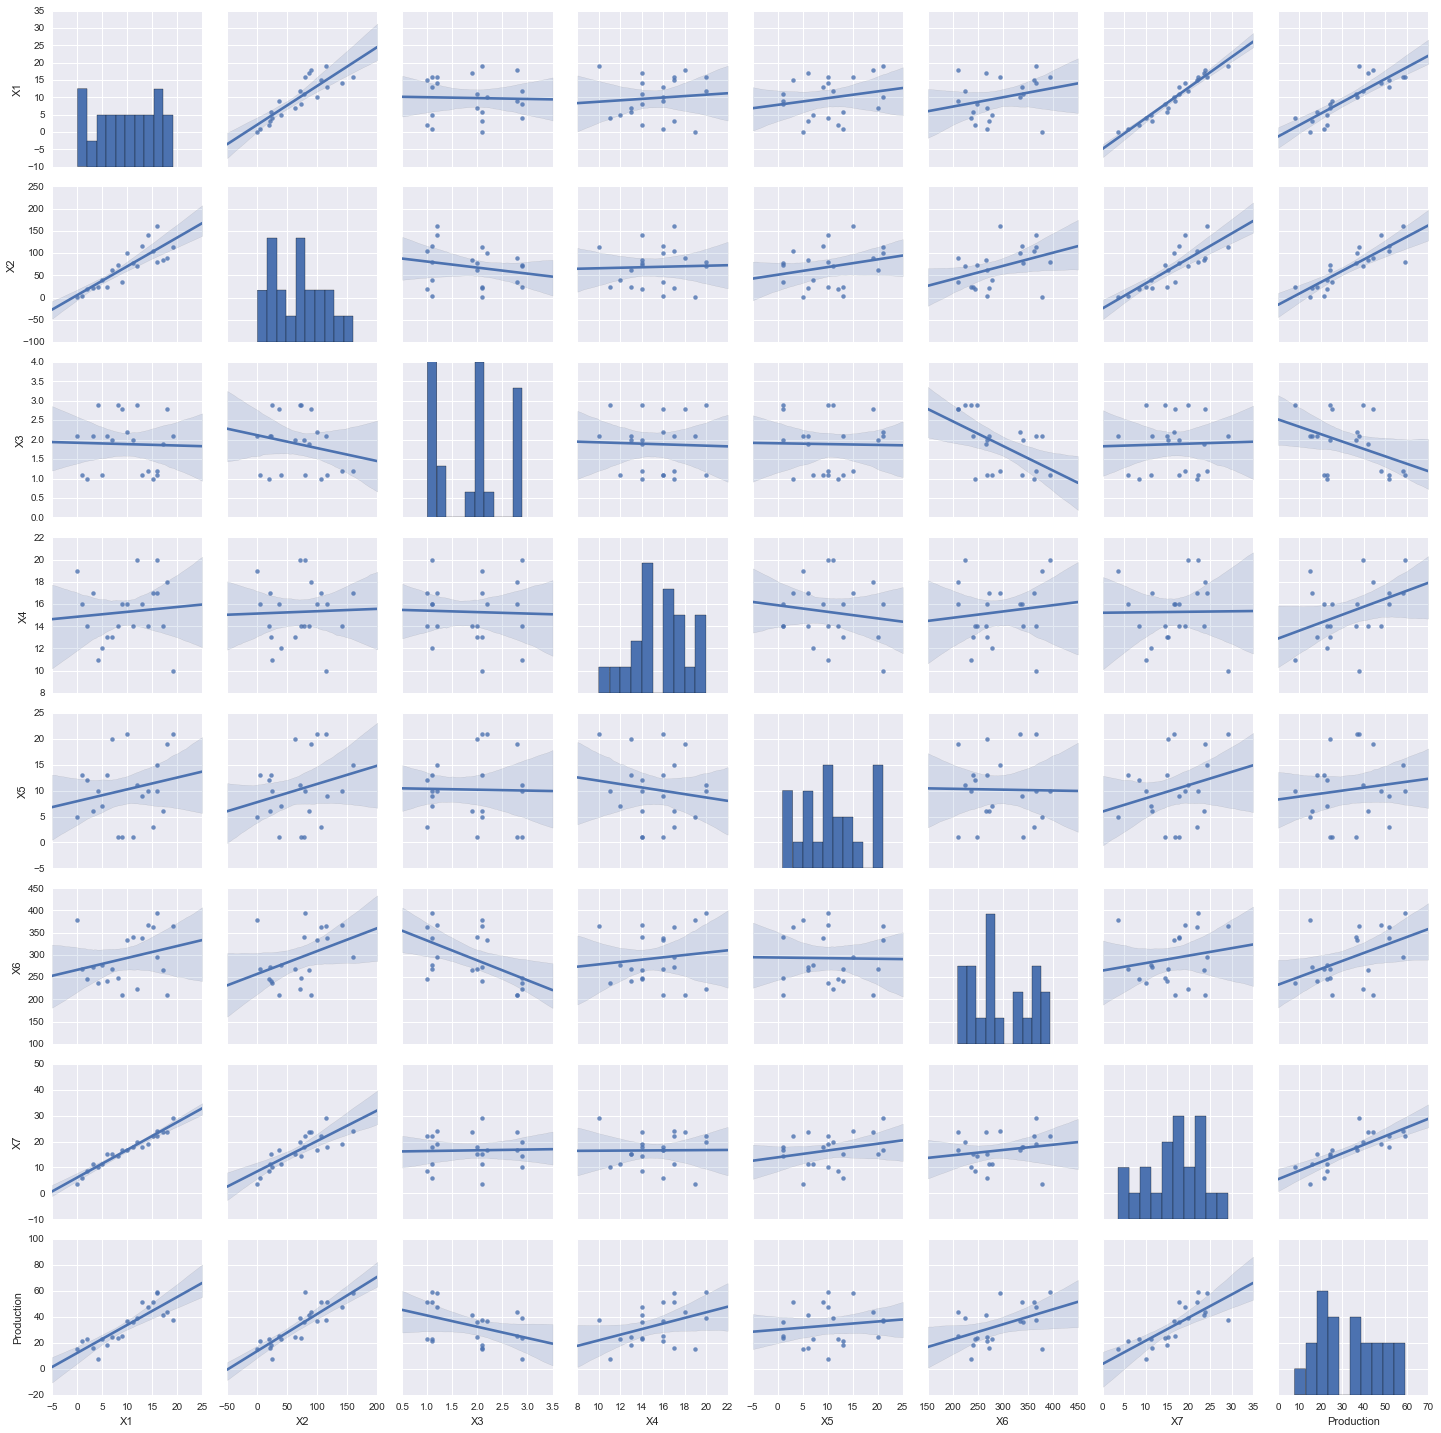

In [7]:
sns.pairplot(data, kind="reg")
plt.show()

If we look at the scatterplots above, some linear relationship among independent variable pairs are obvious, for example between X2 and X1, and between X7 and X1.

If particular, the latter, shows what seems like a strong linear relationship with almost no scatter, and a very tight confidence interval. 

I plot it again below for convenience. I also expect the correlation coefficient to be nearly one.

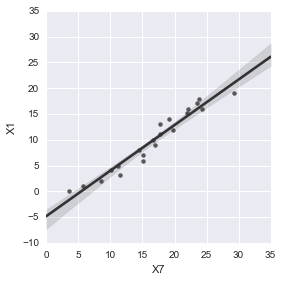

In [8]:
g = sns.PairGrid(data, y_vars=["X1"], x_vars=["X7"], size=4)
g.map(sns.regplot, color="0.2")
plt.show()

In [9]:
data.corr(method = 'spearman').loc['X1','X7']

0.98051948051948057

*quod erat demonstrandum!*

In **Too many seismic attributes? (Barnes, 2016, Reference 2)** Arthur Barnes shows how to screen seismic attributes that are obviously redundant (e.g. they carry almost exactly the same information) by looking for similar linear relationships (and quadratic as well) with very little scatter. I really recommend reading his paper, it is an eye-opener about seismic attributes in general.

However, with an increasing number of attributes (and in fact, to me, this is already plenty), this visual assessment becomes very tedious.

In the  <a href="https://github.com/mycarta/predict/blob/master/Geoscience_Machine_Learning_notebook_1.ipynb"> first notebook</a> I suggested as an alternative the use of a correlation matrix heatmap annotated with the pairwise correlation coefficient.

Even better, we can automate the task of highlighting those linear relationships between independent variables. Here's how you can do it. First we look at the correlation matrix, jsut to have it handy.

In [10]:
data.corr(method = 'spearman') 

,X1,X2,X3,X4,X5,X6,X7,Production
X1,1.000000,0.875325,-0.028835,0.136672,0.188988,0.187135,0.980519,0.868831
X2,0.875325,1.000000,-0.142863,0.050595,0.193550,0.367122,0.828571,0.861039
X3,-0.028835,-0.142863,1.000000,-0.017241,0.013154,-0.501658,-0.015073,-0.328323
X4,0.136672,0.050595,-0.017241,1.000000,-0.127601,0.117364,0.191866,0.384390
X5,0.188988,0.193550,0.013154,-0.127601,1.000000,-0.069449,0.207887,0.117303
X6,0.187135,0.367122,-0.501658,0.117364,-0.069449,1.000000,0.165692,0.331384
X7,0.980519,0.828571,-0.015073,0.191866,0.207887,0.165692,1.000000,0.854545
Production,0.868831,0.861039,-0.328323,0.384390,0.117303,0.331384,0.854545,1.000000


The cell below generates the same heatmap shown in the previous notebook. The only difference is that I added a line to eliminate labels for the main diagonal.

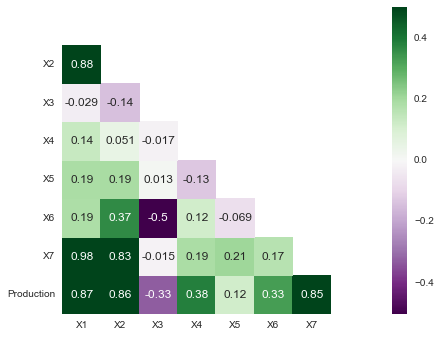

In [11]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr() , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
h = sns.heatmap(data.corr(method = 'spearman') ,annot=True,  mask=mask, cmap='PRGn', vmax=.3, square=True)

# Make labels nice and eliminate main diagonal ones
xlabels = [item.get_text() for item in h.get_xticklabels()]
xlabels[-1] = ''
h.set_xticklabels(xlabels)
ylabels = [item1.get_text() for item1 in h.get_yticklabels()]
ylabels[-1] = ''
h.set_yticklabels(ylabels)
plt.yticks(rotation=0)

plt.show()

The next two blocks of code create a boolean flag for linearly correlated attributes. I use as a criteria the Spearman correlation coefficient (in absolute value) and set a threshold at 0.85 (this value is my personal choice).

The flag is then used as a mask to highlight those coefficients in the heatmap, using coloured Matplotlib patches. The Production row is excluded.

In [12]:
a = np.abs(data.corr(method = 'spearman')) # absolute values of pair-wise spearman correlation coefficients

mask = np.ones(a.shape, dtype=np.bool)     # create a mask where data.corr() is True
mask[np.triu_indices(len(a))] = False      # turn mask's upper triangle to False (including diagonal)

mask = np.isfinite(a[(a>=0.85)&mask])      # turn rest to False unless spearman is greater than the desired threshold

print mask

               X1     X2     X3     X4     X5     X6     X7 Production
X1          False  False  False  False  False  False  False      False
X2           True  False  False  False  False  False  False      False
X3          False  False  False  False  False  False  False      False
X4          False  False  False  False  False  False  False      False
X5          False  False  False  False  False  False  False      False
X6          False  False  False  False  False  False  False      False
X7           True  False  False  False  False  False  False      False
Production   True   True  False  False  False  False   True      False


In [13]:
mask = np.flipud(mask)               # Cell indexing in sns.heatmap is 0 based with origin at bottom left
mask = zip(*np.where(mask == True))  # Create list of tuples from mask to add patches to heatmap

X_mask = [i for i in mask if i[1] != 0] # The Production row is excluded

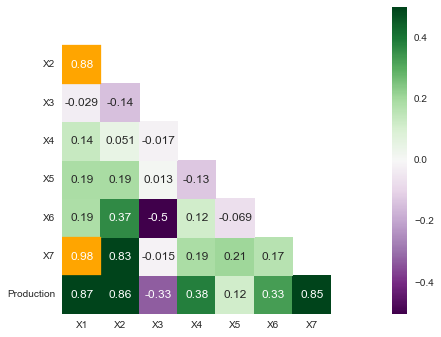

In [14]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
h = sns.heatmap(data.corr(method = 'spearman') ,annot=True,  mask=mask, cmap='PRGn', vmax=.3, square=True)

# Make labels nice and eliminate main diagonbal ones
xlabels = [item.get_text() for item in h.get_xticklabels()]
xlabels[-1] = ''
h.set_xticklabels(xlabels)
ylabels = [item1.get_text() for item1 in h.get_yticklabels()]
ylabels[-1] = ''
h.set_yticklabels(ylabels)
plt.yticks(rotation=0)

# draw patches
for tp in X_mask:
    h.add_patch(Rectangle(tp, 1, 1, fill=True, color = 'orange')) 
plt.show()

Great! 

Now we can focus our attention on the specific relationships between X1-X2, and X1-X7, and decide which of these variables we will use to predict production. It is very important to understand these relationships, and try to uncover possible dependence as X1, X2, and X7 are the three variables with the highest correlation coefficient to production.

We will use all the statistical information, in conjunction with our domain knowledge of petroleum geology. To do that, I will now lift the veil on the names for these three variables.

We read the names from a different file.

In [15]:
with open('Table2_Hunt_2013_edit.csv') as f:
    firstline = f.readline()[:-1]      # read off the first line, except for newline character /n
    values = firstline.split(',')      # split it on the comma
    colnames = list(values)            # make it a list of names

In [16]:
data = data.rename(columns={'X1': colnames[0], 
                            'X2': colnames[1],
                            'X7': colnames[6]})
data.describe()

,Gross pay,Phi-h,X3,X4,X5,X6,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,10.190476,292.714286,16.579524,33.428571
std,5.948521,45.167894,0.708721,2.759400,6.439092,59.429069,6.543793,15.141909
min,0.100000,0.500000,1.000000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,13.000000,340.000000,21.970000,44.200000
max,19.100000,160.000000,2.900000,20.000000,21.000000,395.000000,29.250000,59.200000


X1 is the gross pay in meters.

X2 is Phi-h, porosity multiplied by thickness, with a 3% porosity cut-off.

X7 is a made-up  variable: I created it specifically for this exercise by passing X7 to a logarithmic function, and then adding a bit of normally distributed random noise, <a href= "https://github.com/mycarta/predict/blob/master/Geoscience_Machine_Learning_support_for_notebook_2.ipynb"> as shown in this support notebook</a>. 

Let's redraw the heatmap and the scatterplots, then we can continue the discussion.

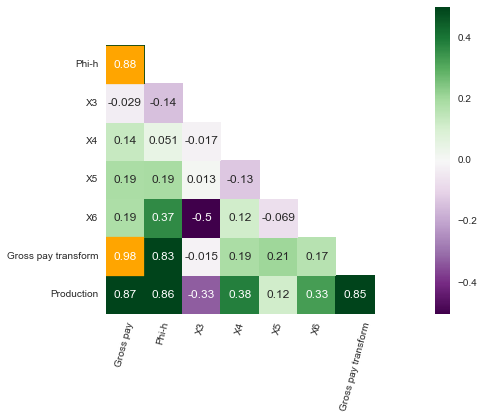

In [17]:
# Draw the heatmap with the mask and correct aspect ratio
h = sns.heatmap(data.corr(method = 'spearman') ,annot=True,  mask=mask, cmap='PRGn', vmax=.3, square=True)

# Make labels nice and eliminate main diagonbal ones
xlabels = [item.get_text() for item in h.get_xticklabels()]
xlabels[-1] = ''
h.set_xticklabels(xlabels)
plt.xticks(rotation=75)
ylabels = [item1.get_text() for item1 in h.get_yticklabels()]
ylabels[-1] = ''
h.set_yticklabels(ylabels)
plt.yticks(rotation=0)

# draw patches
for tp in X_mask:
    h.add_patch(Rectangle(tp, 1, 1, fill=True, color = 'orange')) 
plt.show()

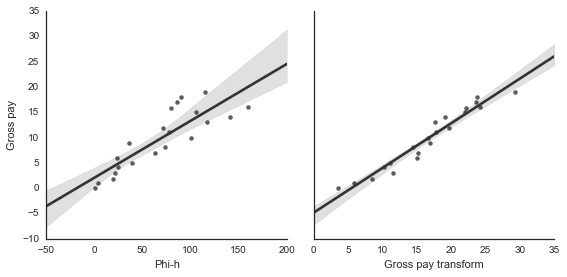

In [18]:
g = sns.PairGrid(data, y_vars=["Gross pay"], x_vars=["Phi-h", "Gross pay transform"], size=4)
g.map(sns.regplot, color="0.2")
plt.show()

I plotted these scatterplots using Gross pay on the y axis, because that is the variable that correlates the most with production (r = 0.87) so I anticipate this will be the driving contributor to our prediction of production.

Phi-h includes a thickness term so I expect a partial dependence between the Phi-h and Gross pay. However, because there's a physical expectation of a relationship between production and Phi-h, the latter should be used in a multi-variate prediction.

There are other tools, that can be used at a later stage, that will tell us how much new information each variable will add. For example, Hunt uses step-wise regression, whereby attributes are added one by one and the multi-variate correlation coefficient is recalculated each time and plotted against variable number. A similar approach in Machine learning (for example when using a random forest classifier), is a plot of relative feature importance. Also comparing the training error versus testing error as each new variable is added, will be useful in this respect, as it will show when the training error stops decreasing, indicating that adding more variables will result in overfitting.

For the Gross Pay transform, we know now it is a made up variable. But it could just as well have been one of those redundant attributes described by Barnes. Let's pretend it is, and call it X7 again. We assume it is a genuine attribute and we give it a chance just like we did with the rest, especially because of its high correlation with Production. But the conclusion, because the correlation coefficient between Gross pay and X7 is nearly 1, and because we do not have a physical explanation for the relationship between X7 and Production, is that we should reject this attribute (Hughes et al., as quoted in Hunt, suggest in their book on Critical thinking, that data alone does not make an argument, and that we should be careful in using data that lacks a reasonable claim of physical or causal relationship).

##### PART 2 - independent variables uncorrelated to the target

In the next section we will look at how to screen the remaining variables base on their relationship with the variable we want to predict, Production.

We first look at the scatterplots.

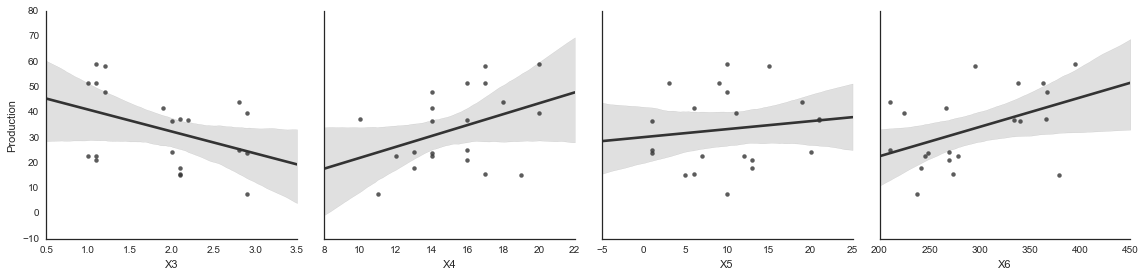

In [19]:
g = sns.PairGrid(data, y_vars=["Production"], x_vars=["X3", "X4", "X5", "X6"], size=4)
g.map(sns.regplot, color="0.2")
plt.show()

All 4 scatterplot seem to have a lot more scatter, and wide confidence intervals. But we want to quantify the goodness of the relationship with production.

#### Critical r test

A good way is to compare the correlation coefficient to a threshold value called critical r. From the definitions, critical r is the value of the correlation coefficient at which you can rule out chance as an explanation for the relationship in the sample.

But first, let's get the variable names for X3 and X4; from Hunt's paper we know these are:
- ranked position within the reservoir, with 1 representing upper facies, 2 the middle, 3 lower ones
- pressure draw-down in MPa

In [20]:
data = data.rename(columns={'X3': colnames[2], 
                            'X4': colnames[3]})
data.describe()

,Gross pay,Phi-h,Position,Pressure,X5,X6,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,10.190476,292.714286,16.579524,33.428571
std,5.948521,45.167894,0.708721,2.759400,6.439092,59.429069,6.543793,15.141909
min,0.100000,0.500000,1.000000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,13.000000,340.000000,21.970000,44.200000
max,19.100000,160.000000,2.900000,20.000000,21.000000,395.000000,29.250000,59.200000


To calculate the critical r, we first get the number of wells and degrees of freedom.

In [21]:
nwells, nfeatures = data.shape
print 'nunber of wells =', nwells
print 'df =' ,nwells-2

nunber of wells = 21
df = 19


Further, we need to calculate the critical t (or inverse t) for the specific significance level (95%) and degrees of freedom we are considering. This can be found in Student's t distribution tables, but fortunately we can also calculate it using the statistical library from Scipy.

With alpha = 0.05 and df = (21 - 2) = 19, we get:

In [22]:
t = sp.stats.t.isf(0.025, nwells-2) # required input is alpha/2

which corresponds to the value we would get from <a href="http://growingknowing.com/GKStatsBookStudentTTable.html"> the Student's t distribution tables</a> at row 19 (df = 19), column 3 (2-tail alpha = 0.05).

With this value of t we calculate the critical r as (<a href="http://brownmath.com/stat/correl.htm#DecisionPoints">formula from Brown</a>):


$$ r = t/√(df+t^2)$$(Eq. 1) 

In [23]:
r_crit = t/np.sqrt((nwells-2)+ np.power(t,2))
print r_crit

0.432857556317


What is this number telling us?

It tells us that with 21 wells (19 degrees of freedom) and 5% as the maximum chance of being wrong we are willing to take (confidence level 95%),  we need a value of correlation coefficient of at least 0.43 to rule out chance as an explanation for a specific correlation.

Remember that the test must be done separately by comparing r with 0.43 for each of the independent variables we want to use to predict production.

And now we can turn the above in a convenient function, and then use it to test all correlation coefficients against it.

In [24]:
def r_crit(nwells, alpha):
    t = sp.stats.t.isf(alpha/2, nwells-2)
    return t/np.sqrt((nwells-2)+ np.power(t,2)) 

In [25]:
rc = r_crit(21,0.05)
print rc

0.432857556317


Below are the correlation coefficients. We are interested in the last row in this case.
For each of those correlation coefficients, if its absolute value is greater than the critical r, then there is nonzero correlation in the population between the specific independent variable and production, in same direction (sign) as the sample.

In [26]:
data.corr('spearman')

,Gross pay,Phi-h,Position,Pressure,X5,X6,Gross pay transform,Production
Gross pay,1.000000,0.875325,-0.028835,0.136672,0.188988,0.187135,0.980519,0.868831
Phi-h,0.875325,1.000000,-0.142863,0.050595,0.193550,0.367122,0.828571,0.861039
Position,-0.028835,-0.142863,1.000000,-0.017241,0.013154,-0.501658,-0.015073,-0.328323
Pressure,0.136672,0.050595,-0.017241,1.000000,-0.127601,0.117364,0.191866,0.384390
X5,0.188988,0.193550,0.013154,-0.127601,1.000000,-0.069449,0.207887,0.117303
X6,0.187135,0.367122,-0.501658,0.117364,-0.069449,1.000000,0.165692,0.331384
Gross pay transform,0.980519,0.828571,-0.015073,0.191866,0.207887,0.165692,1.000000,0.854545
Production,0.868831,0.861039,-0.328323,0.384390,0.117303,0.331384,0.854545,1.000000


Again, we can create a mask to highlight directly in the heatmap the coefficients that fail the test.

In [27]:
mask = np.zeros_like(data.corr(method = 'spearman') , dtype=np.bool) # Create a mask where data.corr() is False
mask[np.tril_indices_from(mask)] = True                              # Set mask's upper triangle to True
mask = np.isfinite(a[(a<rc)&mask])                               # Turn back to False if passing critical r test


mask = np.flipud(mask)               # Cell indexing in sns.heatmap is 0 based with origin at bottom left
mask = zip(*np.where(mask == True))  # Create list of tuples from mask to add patches to heatmap

y_mask = [(i) for i in mask if i[1] == 0]
y_mask

[(2, 0), (3, 0), (4, 0), (5, 0)]

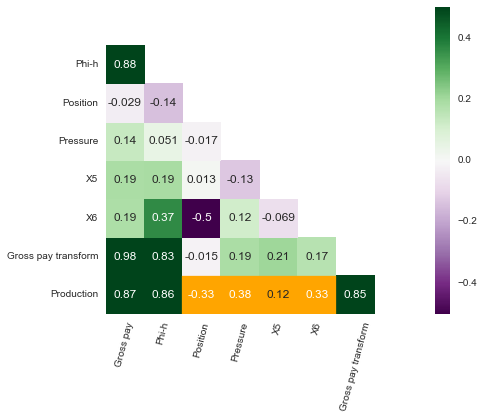

In [28]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
h = sns.heatmap(data.corr(method = 'spearman') ,annot=True,  mask=mask, cmap='PRGn', vmax=.3, square=True)

# make labels nice and eliminate diagonbal ones
plt.xticks(rotation=75)
xlabels = [item.get_text() for item in h.get_xticklabels()]
xlabels[-1] = ''
h.set_xticklabels(xlabels)
ylabels = [item1.get_text() for item1 in h.get_yticklabels()]
ylabels[-1] = ''
h.set_yticklabels(ylabels)

# add patches
for tp in y_mask:
    h.add_patch(Rectangle(tp, 1, 1, fill=True, color = 'orange')) 

And here is a printed summary of the test results:

In [29]:
r_crit_test = pd.DataFrame(data.corr(method = 'spearman').loc['Production'][:-2] >= rc).T
r_crit_test

,Gross pay,Phi-h,Position,Pressure,X5,X6
Production,True,True,False,False,False,False


So we see that Position, Pressure, X5, and X6 fail the critical test.
How do we use this knowledge?

The answer is that we again combine the statistical result with our domain knowledge. As Lee Hunt points out, our prior knowledge of production suggests it may be a multi-variate problem, and that pressure and position should matter in a multi-variate prediction in spite of their critical r test failure.
He quotes Fisher (1935, The design of experiments) to reinforce the idea we should use all the information at our disposal, if there is a reasonable justification in terms of physical or causal relationship, which in the case of position and pressure we do have. 

For X5 and X6 things are different. If you've read Hunt's paper you would know these are randomly generated variables, with no relationship to production. If these were real measurements, the apparent, weak correlation, is just the luck of the draw.

But let's again for a minute pretend we do not know these are mad-up variables. How could we decide whether to use them or not in our multi-variate prediction?

We can dig a bit deeper, but introducing a new test.

#### Kalkomey's probability of spuriousness

In the context of a single (seismic) attribute as a possible predictor of a reservoir porperty, **Kalkomey (1997, Reference 3)** defined spuriousness as the probability of observing the absolute value of the sample correlation, r, being greater than some constant, R, given the true (population) correlation ρ is zero is given by:

$$p=Pr(|r|≥R)=|t|≥((R√(n-2))/√(1-R^2 ))$$(Eq. 2)

where n is the sample size or number of locations (the wells) with measurements of both the reservoir property and the seismic attribute, and t is the Student’s t distribution with n-2 degrees of freedom.

This probability of spuriousness p is the same as the well-known p-value, and we can rephrase the above as per my definition of p-value: p it is the probability of getting a sample with at least the correlation coefficient we just got or even higher, purely by chance.

The function below calculates p:

In [30]:
def P_spurious (r, nwells):
    t_of_r = r * np.sqrt((nwells-2)/(1-np.power(r,2)))  # comment t from Brown (critical t?)
    return sp.stats.t.sf(np.abs(t_of_r), nwells-2)*2 

Notice that the probability of spuriousness depends solely on the number of wells n and the magnitude R of the spurious sample correlation.

We want to use the function to get p for R ranging between 0 to 1, and the number of wells ranging between 5 and 25, to recreate Table 1 in Kalkomey's paper, where rows have constant values of R, and columns constant number of wells.

In [31]:
ps = np.asarray([P_spurious(R, np.arange(5,26,1)) for R in (np.arange(0.0,1.05,0.05))])

tol = 0.01                           # a little tidier if we set very small numbers equal to zero
ps.real[abs(ps.real) < tol] = 0.0

In [32]:
ps = pd.DataFrame(ps, index = [" R=" + mp for mp in map(str, (np.arange(0.0,1.05,0.05)))], 
                  columns = [" n=" + mp for mp in map(str, (np.arange(5,26,1)))])

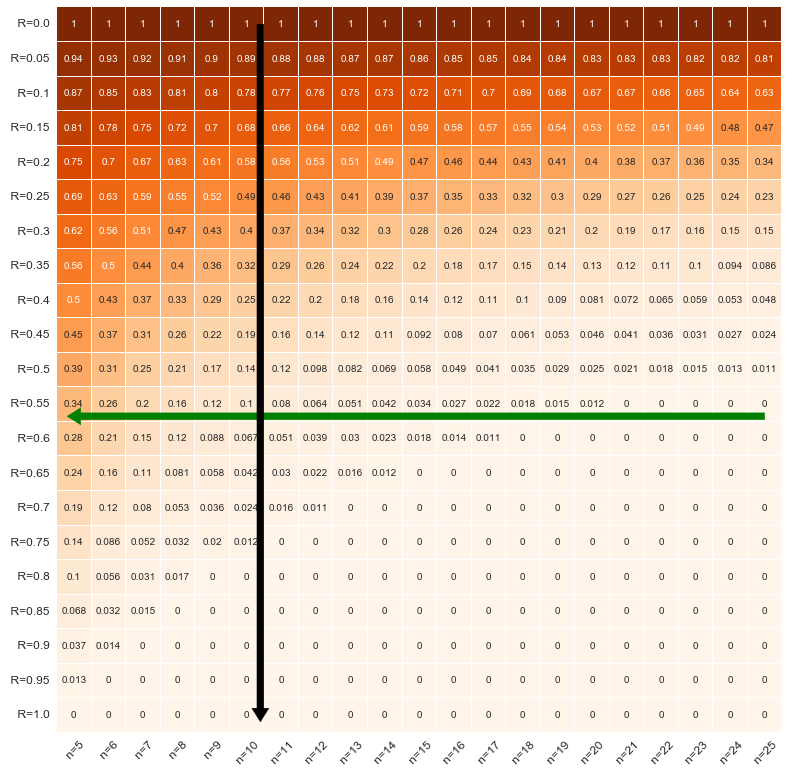

In [33]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(ps, annot=True,annot_kws={"size": 10}, cmap='Oranges', square=True, linewidths=0.01, cbar=False)
plt.yticks(rotation=0) 
plt.xticks(rotation=45)

ax.arrow(20.5,9.15,-19.8,0,fc='g',ec='g',width = 0.2, head_width=0.5, head_length=0.4)
ax.arrow(5.9,20.5,0,-19.8,fc='k',ec='k',width = 0.2, head_width=0.5, head_length=0.4) 

plt.show()

Below are a couple of hypothetical but practical examples of how to use this table. 

Let's say we are convinced we've found a great new attribute - a single one - to predict production in the reservoir directly from 3D seismic, and we have production from existing wells to corroborate the relationship.

With 10 wells (along the black arrow) you would need at least a correlation coefficient of 0.6 to reduce to less than 10% the the chance that the relationship is spurious, in other words just the lack of the draw with these 10 wells.

Conversely, with a correlation coefficient of 0.55 (along green arrow) and 20 wells the chance of spuriousness is next none (1%); with 15 wells it is still as low as 3%, with 10 wells it is 10%, and with 5 wells it is 34%, in other words 1 in 3 chances. 

It seems like p increases exponentially when linearly decreasing the number of wells!

Let's go back to our production example now. Neither X5 nor X6 passed the critical r test. Their correlation coefficient were, respectively, 0.12 and 0.33. Let's read the chance of spuriousness associated with these values (remember we have 21 wells).

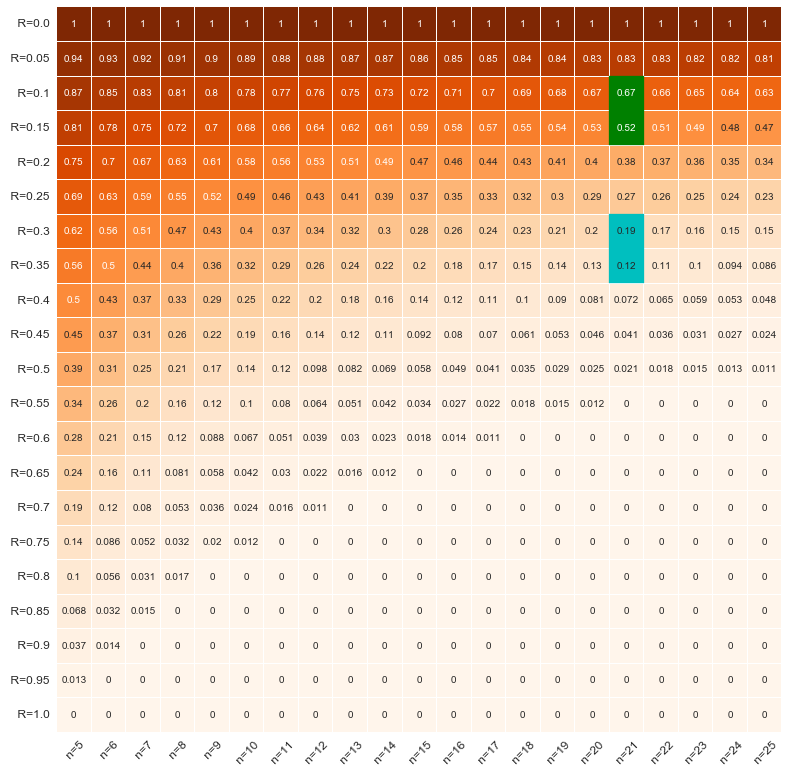

In [34]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(ps, annot=True,annot_kws={"size": 10}, cmap='Oranges', square=True, linewidths=0.01, cbar=False)
plt.yticks(rotation=0) 
plt.xticks(rotation=45)
ax.add_patch(Rectangle((16, 13), 1, 1, fill=True, color='c')) 
ax.add_patch(Rectangle((16, 14), 1, 1, fill=True, color='c')) 
ax.add_patch(Rectangle((16, 17), 1, 1, fill=True, color='g')) 
ax.add_patch(Rectangle((16, 18), 1, 1, fill=True, color='g')) 
plt.show()

#### Discussion

Now we have all the information we need. 

Let's summarize:

- X5 failed the critical r test by a lot, with r = 0.12, and from the table above we get a chance of spuriousness between 52% and 67%. The choice is easy, we drop this variable.

- X6 failed the critical r test but not by not so much, with r = 0.33, and we read a chance of spuriousness between 12% and 19%. Perhaps we would be willing to take the  risk of using this variable. After all, the correlation coefficient for Position is also 0.33 and the chance of spuriousness would be the same. The big difference however is in that we we do not have any domain knowledge of what X6 is; in other words, we do not have a physical explanation for the relationship between X6 and Production. We should therefore reject X6 as predictor. It is less costly to do so in such cases (we incur in a Type II error) than to use it when the relationship is spurious (Type I error), as illustrated in both **Kalkomey** and **Chambers and Yarus**. And in this case we're sure we would do the right thing because we know X6 is a random variable.

OK. We're done.

The final dataset is:

In [35]:
data = data.drop(['X5','X6','Gross pay transform'], axis=1)
data.describe()

,Gross pay,Phi-h,Position,Pressure,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,33.428571
std,5.948521,45.167894,0.708721,2.759400,15.141909
min,0.100000,0.500000,1.000000,10.000000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,44.200000
max,19.100000,160.000000,2.900000,20.000000,59.200000


By the way, since we put all this work together, it's nice to get a quick best fit on the production using the 4 remaining predictors. We can try:

1) Ordinary Least Square in Statsmodels

2) Linear Regression fit in Scikit-learn

In [ ]:
sort_data = data.sort_values(by='Production', ascending=True)

X = sort_data.loc[:,'Gross pay':'Pressure']
y = sort_data.loc[:,'Production']

##### Ordinary Least Square in Statsmodels

In [36]:
import statsmodels.api as sm

model = sm.OLS(y, X)
results = model.fit()
# print results.summary() 

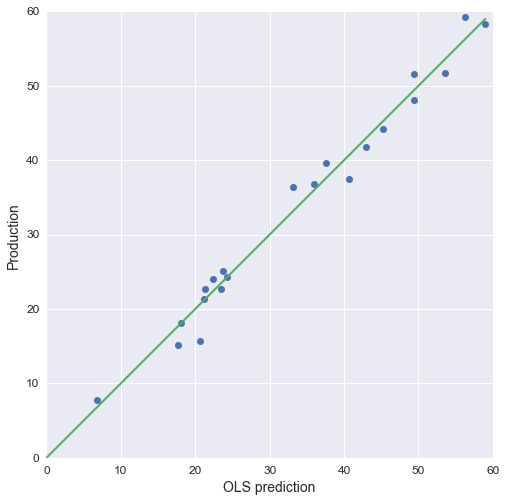

In [37]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(results.predict(), y, 'o', lw=2)
ax1.plot(np.arange(0, max(y), dtype = int), np.arange(0, max(y), dtype = int), '-', lw=2)
ax1.set_ylabel('Production', fontsize = '14')
ax1.set_xlabel('OLS prediction', fontsize = '14')

plt.show()

And we can display some of the result statistics:

In [62]:
print 'R-squared = ', results.rsquared
print '\nParameters:'
print results.params

R-squared =  0.996913029857

Parameters:
Gross pay    1.381771
Phi-h        0.103518
Position    -6.852485
Pressure     1.680139
dtype: float64


OLS gives similar results to multi-linear regression in terms of R-squared (which is 0.998 in Hunt's paper), but lower accuracy in the estimate of the parameters.

##### Linear regression fit in Scikit-learn

In [65]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression(normalize=True)
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

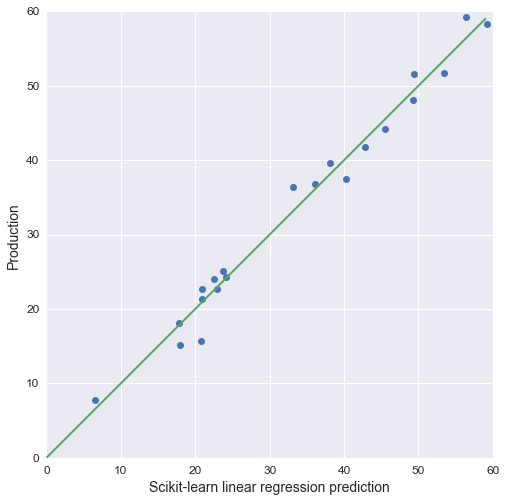

In [68]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(regr.predict(X), y, 'o', lw=2)
ax1.plot(np.arange(0, max(y), dtype = int), np.arange(0, max(y), dtype = int), '-', lw=2)
ax1.set_ylabel('Production', fontsize = '14')
ax1.set_xlabel('Scikit-learn linear regression prediction', fontsize = '14')

plt.show()

In [66]:
# print 'Intercept: \n', regr.intercept_
print 'R-squared = ', regr.score(X, y)
print '\nCoefficients:'
print 'Gross pay = ', regr.coef_[0]
print 'Pi-h      = ', regr.coef_[1]
print 'Position  = ', regr.coef_[2]
print 'Pressure  = ', regr.coef_[3]

R-squared =  0.981399829875

Coefficients:
Gross pay =  1.36818129285
Pi-h      =  0.106817275939
Position  =  -6.65751242115
Pressure  =  1.75937080163


Scikit-learn Linear Regression gives slightly inferior results of both multi-linear regression and OLS in terms of R-squared (which is 0.998 in Hunt's paper), and slightly higher accuracy in the estimate of the parameters.

=======================================================================================================================

#### DEFINITIONS

I created this list of hypothesis testing definitions drawing primarily from Stan Brown's<a href="http://brownmath.com/swt/"> Stats without tears</a>, and secondarily form the reference papers below.

For a sample n of measurements (observations) of variable x and variable y, with a linear correlation coefficient, r = 0.5. ρ is the correlation in the population we are trying to make inferences on.

- **null hypothesis**: ρ = 0, the correlation in the population is zero, there is no linear relationship between the two variables. Our sample with its correlation coefficient r was just the luck of the draw.
- **critical r**: the value of the correlation coefficient at which you can rule out chance as an explanation for the relationship in the sample.
- **significance level, alpha**: the chance of being wrong that one accepts to live with; 0.05, or 5%, is a typical choice.
- **degrees of freedom, df**: the number of observations minus the number of parameters to be estimated. In regression, because one observation is spent to estimate the slope, and one to estimate the intercept, df = n-2.
- **p-value**: the probability of getting a sample with at least the correlation coefficient one just got, or even higher, purely by chance. If the p-value is small, the sample is in conflict with the null hypothesis. If the p-value is large, one can reach no conclusions about the population, and cannot reject the null hypothesis. p-value is the same as the **probability of spurious correlation** defined in **Kalkomey**.
- **type I error**: rejecting the null hypothesis when it is actually true, e.g. using the sample to infer a non existing relationship in the population. This is the most costly type of error, leading to an inaccurate prediction with confidence, as described in both **Kalkomey** and **Chambers and Yarus**.
- **type II error**: this error conversely occurs when a real correlation exists in the population but we fail to use the predictor. Type II errors are not as bad as Type I errors because they result in more uncertainty than justified, as opposed to inaccurate prediction with confidence.

#### REFERENCES

1) <a href: "http://csegrecorder.com/features/view/value-of-integrated-geophysics-201312"> Many correlation coefficients, null hypoteses, and high value.</a> Lee Hunt, CSEG Recorder, December 2013.

2) <a href: "http://csegrecorder.com/articles/view/too-many-seismic-attributes"> Too many seismic attributes?</a> Arthur Barnes, CSEG Recorder, March 2006.


3) <a href: "http://library.seg.org/doi/abs/10.1190/1.1437610"> Potential risks when using seismic attributes as predictors of reservoir properties.</a> Cynthia Kalkomey, The Leading Edge, March 1997.

4) <a href: "http://csegrecorder.com/articles/view/too-many-seismic-attributes"> Quantitative use of seismic attributes for reservoir characterization.</a>  Richard Chambers and Jeffrey Yarus, CSEG Recorder, June 2002.